In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [32]:
# Step 1: importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [33]:
df = pd.read_csv('/content/drive/MyDrive/Fraud (2).csv')#loading dataset


In [34]:
# Take a smaller random sample
df = df.sample(n=15000, random_state=42)
print(f"Shape after sampling: {df.shape}")
print(df.head())

Shape after sampling: (15000, 11)
         step      type      amount     nameOrig  oldbalanceOrg  \
3737323   278   CASH_IN   330218.42   C632336343       20866.00   
264914     15   PAYMENT    11647.08  C1264712553       30370.00   
85647      10   CASH_IN   152264.21  C1746846248      106589.00   
5899326   403  TRANSFER  1551760.63   C333676753           0.00   
2544263   206   CASH_IN    78172.30   C813403091     2921331.58   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
3737323       351084.42   C834976624       452419.57       122201.15        0   
264914         18722.92   M215391829            0.00            0.00        0   
85647         258853.21  C1607284477       201303.01        49038.80        0   
5899326            0.00  C1564353608      3198359.45      4750120.08        0   
2544263      2999503.88  C1091768874       415821.90       337649.60        0   

         isFlaggedFraud  
3737323               0  
264914                0 

In [35]:
# 2. Missing Values
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


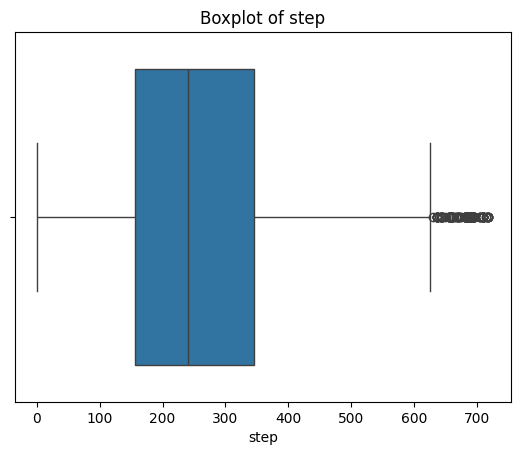

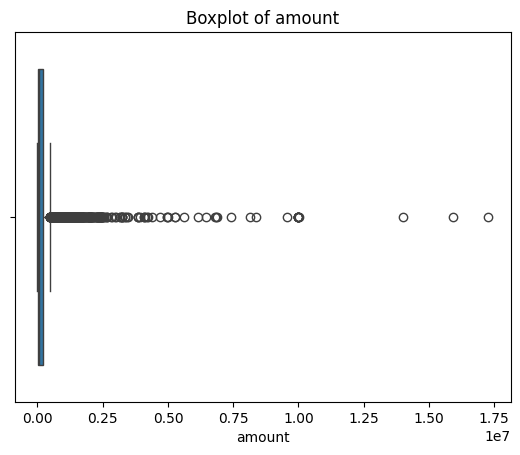

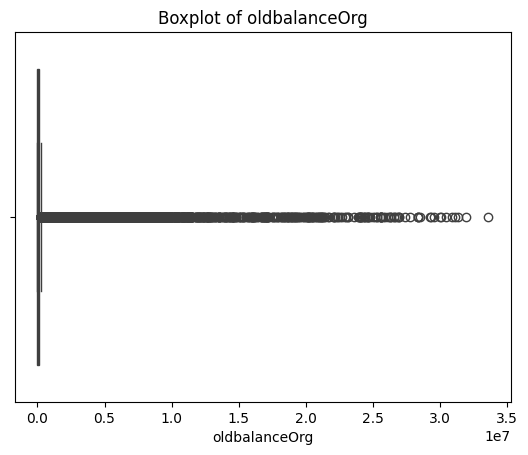

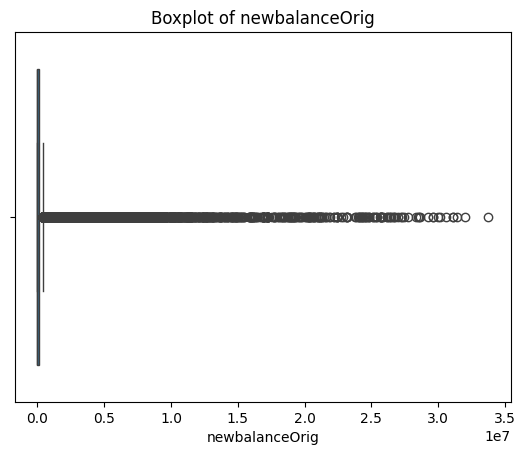

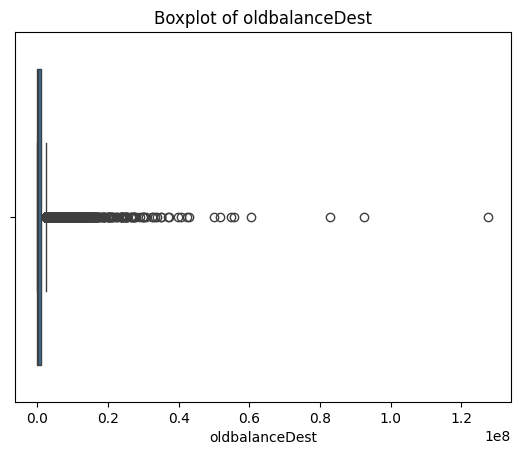

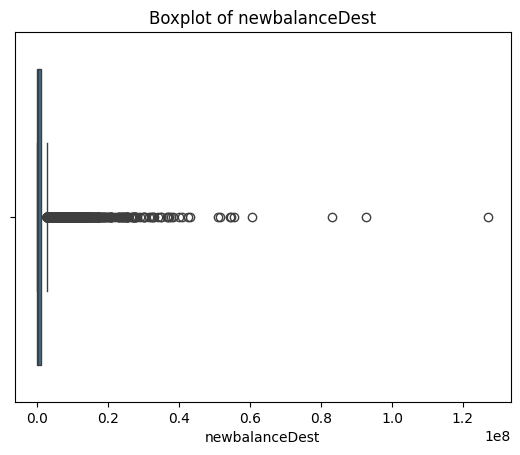

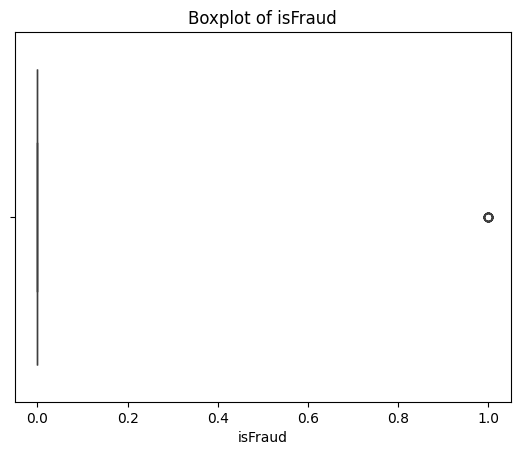

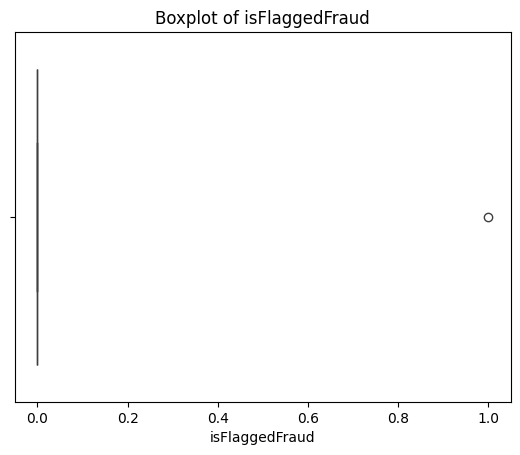

In [36]:
# Outlier Handling
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [37]:
# Multicollinearity Check (Optional, can comment to save time)
X_temp = df.drop('isFraud', axis=1)
X_temp = pd.get_dummies(X_temp)

# Select only numeric features for VIF calculation
X_temp_numeric = X_temp.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data["Feature"] = X_temp_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp_numeric.values, i) for i in range(X_temp_numeric.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data.sort_values(by="VIF", ascending=False))


Variance Inflation Factors:
          Feature         VIF
3  newbalanceOrig  988.539238
2   oldbalanceOrg  984.057946
5  newbalanceDest   66.396652
4  oldbalanceDest   59.444542
1          amount    3.365095
0            step    1.234025
6  isFlaggedFraud    1.021542


In [38]:
# 4. Prepare Features
target_column = 'isFraud'

X = df.drop(target_column, axis=1)
y = df[target_column]

In [39]:
# Encode categorical variables
X = pd.get_dummies(X)

In [40]:
# 5. Train-Test Split
X_calibration, X_validation, y_calibration, y_validation = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [41]:
# 6. Scaling
scaler = StandardScaler()
X_calibration = scaler.fit_transform(X_calibration)
X_validation = scaler.transform(X_validation)

In [42]:
# 7. Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_calibration, y_calibration)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [44]:
# 8. Predictions
y_pred = model.predict(X_validation)
y_proba = model.predict_proba(X_validation)[:, 1]

In [45]:
# 9. Performance
print("\nClassification Report:")
print(classification_report(y_validation, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4493
           1       0.00      0.00      0.00         7

    accuracy                           1.00      4500
   macro avg       0.50      0.50      0.50      4500
weighted avg       1.00      1.00      1.00      4500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


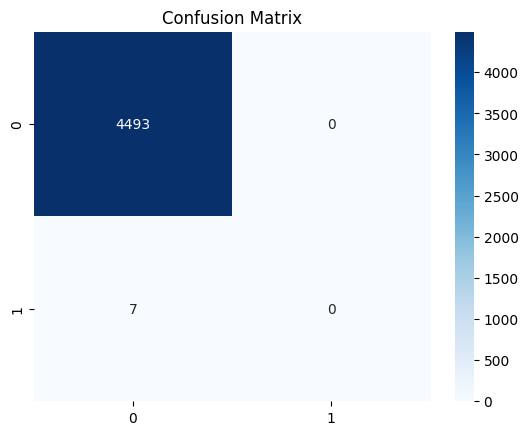

In [46]:
sns.heatmap(confusion_matrix(y_validation, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [47]:
roc_auc = roc_auc_score(y_validation, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9267


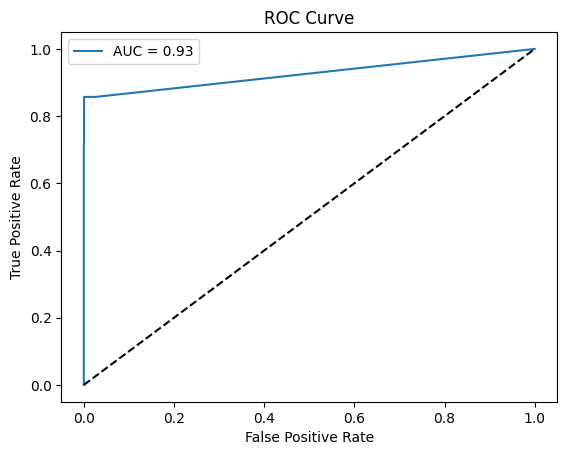

In [48]:
fpr, tpr, _ = roc_curve(y_validation, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [49]:
# 10. Important Features
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
important_features = feature_importances.sort_values(ascending=False)
print("\nTop 10 Important Features:")
print(important_features.head(10))


Top 10 Important Features:
oldbalanceOrg     0.141780
amount            0.108879
step              0.085038
oldbalanceDest    0.069115
newbalanceOrig    0.055734
type_PAYMENT      0.050157
newbalanceDest    0.049702
type_TRANSFER     0.026510
type_CASH_IN      0.026136
type_CASH_OUT     0.023702
dtype: float64


In [50]:
# Step 6: Analysis
print("\nAnalysis:")
print("Yes, features like oldbalanceOrg , amount are logically related to fraudulent behavior.")



Analysis:
Yes, features like oldbalanceOrg , amount are logically related to fraudulent behavior.


In [51]:
# Step 7: Prevention
print("\nPrevention Strategies:")
print("- Real-time fraud detection system using ML predictions.\n- Risk-based authentication.\n- Stronger KYC (Know Your Customer) processes.\n- AI-based anomaly detection systems.")


Prevention Strategies:
- Real-time fraud detection system using ML predictions.
- Risk-based authentication.
- Stronger KYC (Know Your Customer) processes.
- AI-based anomaly detection systems.


In [52]:
# Step 8: Measuring Success
print("\nHow to Measure if Actions Work:")
print("- Compare fraud rates before vs after implementations.\n- Monitor precision and recall of detection system.\n- A/B test new fraud prevention systems.")


How to Measure if Actions Work:
- Compare fraud rates before vs after implementations.
- Monitor precision and recall of detection system.
- A/B test new fraud prevention systems.
